In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.utils.syspathcontext import prepended_to_syspath
from scipy import stats
from keras import models
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
test_dir = os.path.join(dataset_dir, 'balanced_test')

In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

Let's select a model from the saved CNN models from scratch:

In [ ]:
filepath=os.path.join(dir_name, 'L2_model.h5')
# L2_model
#model4
model=keras.models.load_model(filepath)

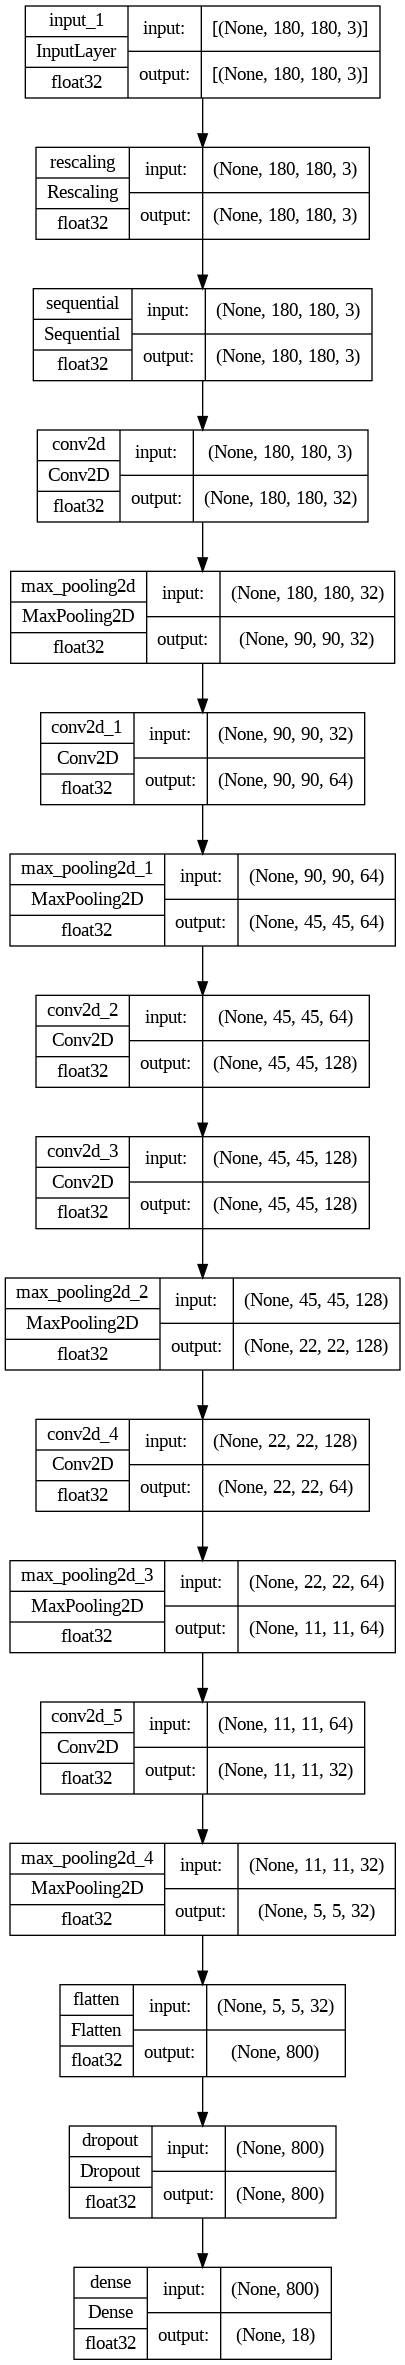

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                             

Let's import un input image not in the training set:

In [ ]:
import keras.utils as image

img_path = os.path.join(test_dir, 'Vincent van Gogh/Vincent_van_Gogh_27.jpg') #389 Vincent van Gogh/Vincent_van_Gogh_800
img = image.load_img(img_path, target_size=(180, 180))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

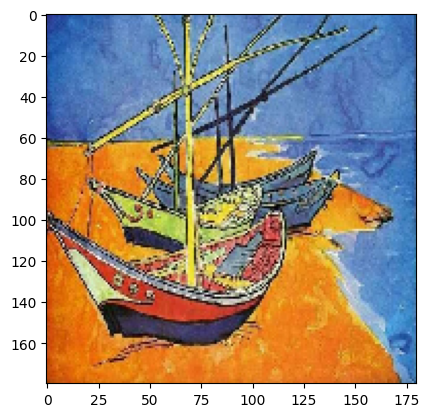

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])

# Visualizing intermediate activations

Let's plot some of the channels of the activation in the first convolutional layers:

In [ ]:
activation_model = models.Model(inputs=model.input, outputs=model.get_layer('conv2d').output)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)
for i in range(20,25):
  plt.matshow(first_layer_activation[:, :, i], cmap='viridis')

NameError: ignored

In [ ]:
# Extract the outputs of the layers
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input
activation_model = keras.models.Model(inputs=[model.inputs], outputs=layer_outputs[3:9])

In [ ]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpyarrays: one array per layer activation

1/1 [==============================] - 0s 89ms/step


Let's plot a complete visualization of all the activations in the network such that in the following figure we can see every channel in each of the activation maps stacked side by side:

<ipython-input-38-9d0cd1e3ac49>:17: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


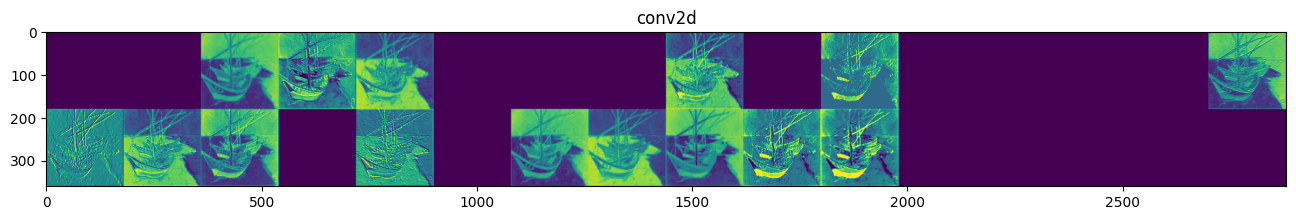

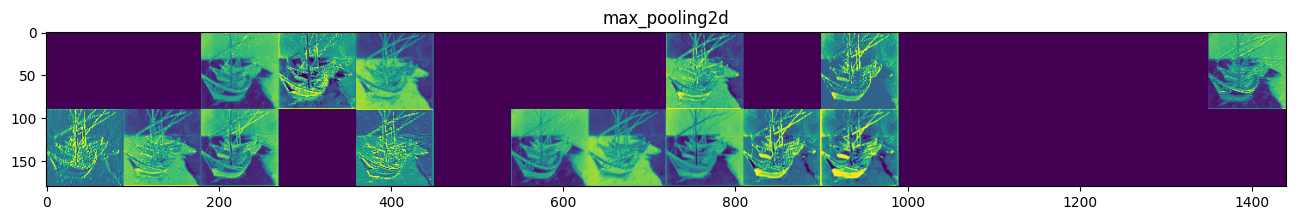

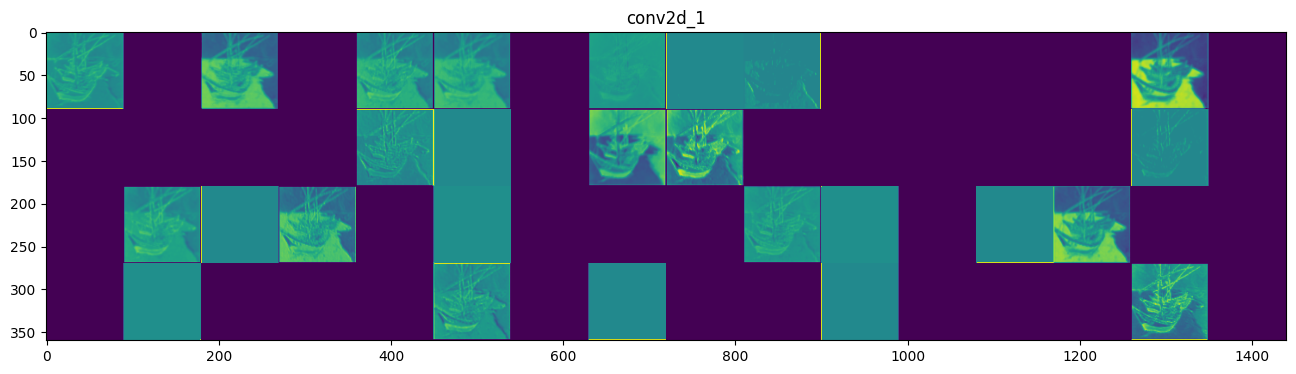

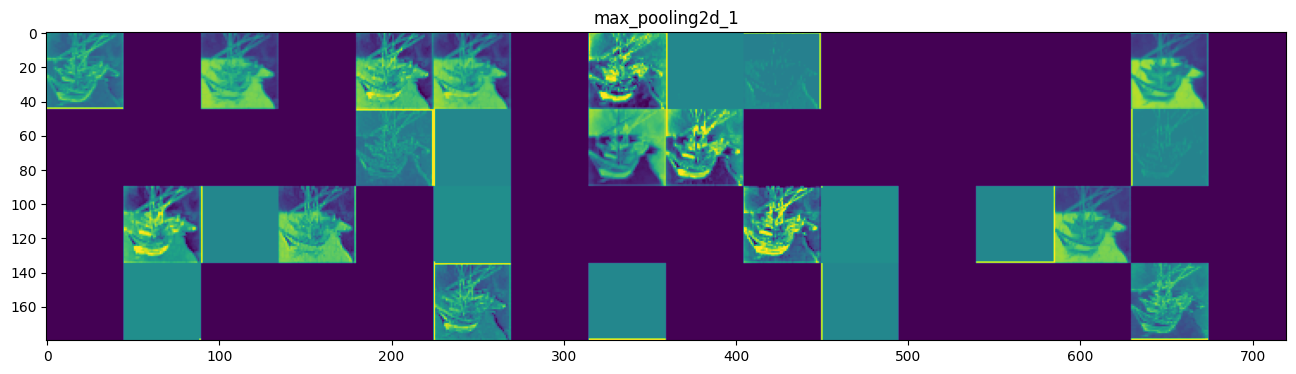

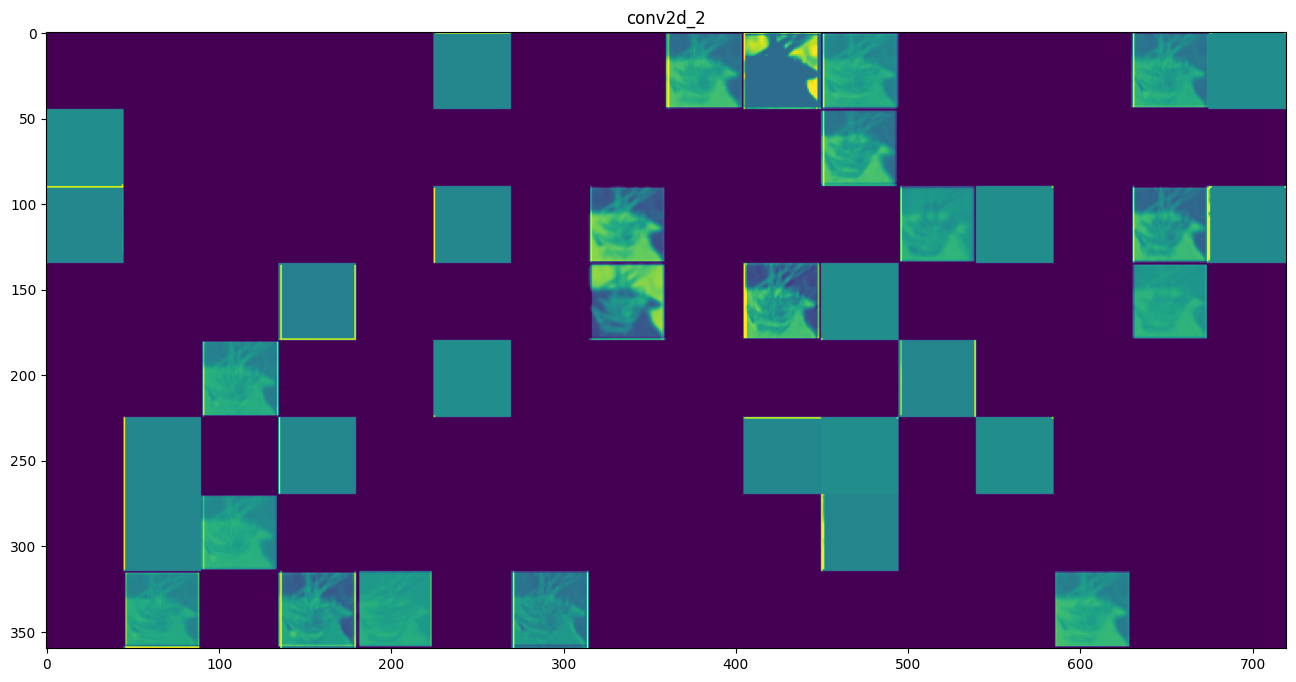

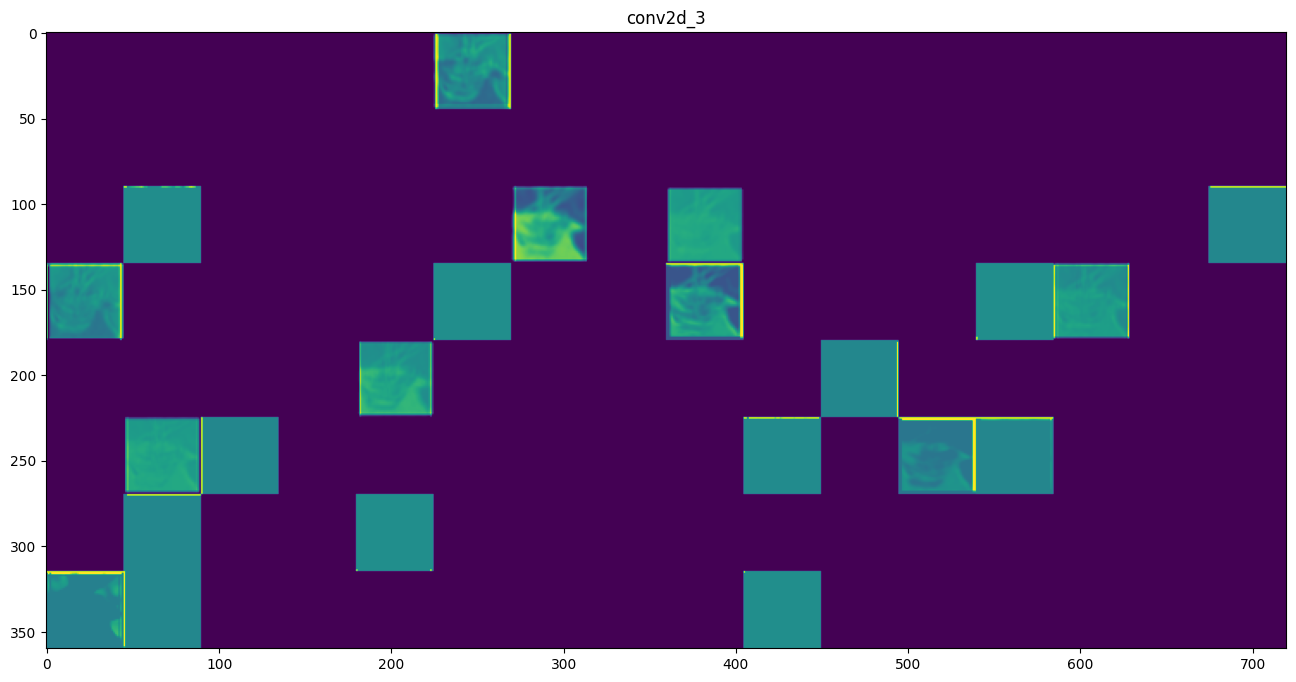

In [ ]:
layer_names = []
for layer in model.layers[3:]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
      
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Visualizing heatmaps of class activation


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
class_names = os.listdir(test_dir)
print(class_names)

['Rene Magritte', 'Edgar Degas', 'Mikhail Vrubel', 'Titian', 'Albrecht Dürer', 'Francisco Goya', 'Andy Warhol', 'Henri Matisse', 'Paul Klee', 'Pierre-Auguste Renoir', 'Alfred Sisley', 'Sandro Botticelli', 'Marc Chagall', 'Vincent van Gogh', 'Amedeo Modigliani', 'Pablo Picasso', 'Paul Gauguin', 'Rembrandt']


In [ ]:
pred = class_names[np.argmax(model.predict(img_tensor))]
pred

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 292ms/step


'Vincent van Gogh'

In [ ]:
layer_name = 'conv2d_5' #conv2d_11
conv_layer = model.get_layer(layer_name)
conv_layer_model = keras.Model(model.inputs, conv_layer.output)

In [ ]:
layer_names = ['max_pooling2d_4', 'flatten', 'dropout' ,'dense'] #L2model
# layer_names = ['max_pooling2d_9', 'flatten_1', 'dropout_2' ,'dense_2','dropout_3','dense_3']


classifier_input = keras.Input(shape=conv_layer.output.shape[1:])
x = classifier_input
for layer_name in layer_names:
    x = model.get_layer(layer_name)(x)

classifier_model = keras.Model(classifier_input, x)

classifier_input = keras.Input(shape=conv_layer.output.shape[1:])
x = classifier_input
for layer_name in layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)


In [ ]:
with tf.GradientTape() as tape:
    conv_layer_output = conv_layer_model(img_tensor) # output feature maps of the last conv layer.
    tape.watch(conv_layer_output)
    preds = classifier_model(conv_layer_output)  
    top_pred_index = tf.argmax(preds[0])  
    top_class_channel = preds[:, top_pred_index] 
    print(top_pred_index)
    print(top_class_channel)

grads = tape.gradient(top_class_channel, conv_layer_output)


tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor([0.88693], shape=(1,), dtype=float32)


In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately
weighted_conv_layer_output = conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    weighted_conv_layer_output[:, :, i] *= pooled_grads[i]


In [ ]:
temp_heatmap = np.mean(weighted_conv_layer_output, axis=-1)
temp_heatmap = np.maximum(temp_heatmap, 0)
heatmap = temp_heatmap/np.max(temp_heatmap)

<ipython-input-49-839d6fcc8f5b>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


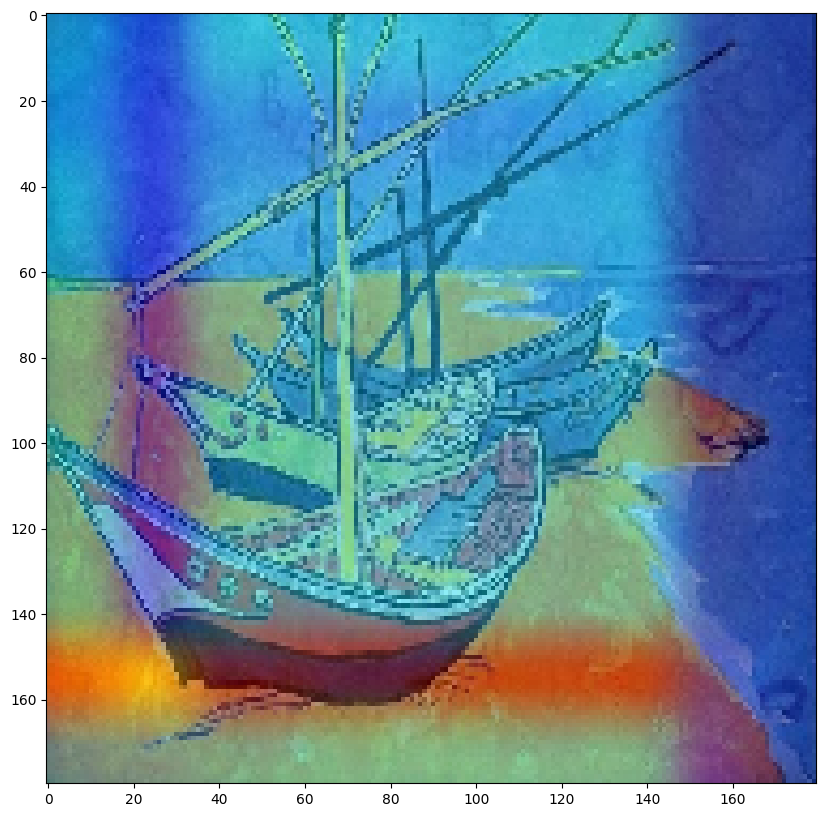

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt


heatmap = np.uint8(255 * heatmap)

img_array = image.img_to_array(img)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
jet_heatmap = image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.8 + img_array
superimposed_img = image.array_to_img(superimposed_img)


plt.figure(figsize= (10,10))
plt.imshow(superimposed_img)